# File Usage Visualization

This notebook is intended to provide an analytical framework for inspecting the FileUsage data structures that are output from the analysis of a user's home directory. These notebooks are not intended to be shipped with the package in PyPI, but rather used for offline analysis by developers. Much of the code in this notebook will be ported to the library for use on the command line. 

In [11]:
%matplotlib inline

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from mosaic.usage import FileUsage
from mosaic.utils import humanize_bytes

# Set the Seaborn style and context
sns.set_style('darkgrid')
sns.set_context('poster')
sns.set_palette('Set1')

In [13]:
# Set the path to the data file you wish to analyze
DATA_FILE     = "../fixtures/mosaic-1448734480.json"
# DATA_FILE     = "../fixtures/mosaic-1448743274.json"

# Dateformats for the analysis
JSON_DATETIME = "%Y-%m-%dT%H:%M:%S.%fZ"
LONG_DATETIME = "%b %d, %Y at %H:%M UTC"

In [14]:
def datefmt(dt, dtpfmt=JSON_DATETIME, dtffmt=LONG_DATETIME):
    return datetime.strptime(dt, dtpfmt).strftime(dtffmt)

## File Usage Description

This section describes the analysis for the data file that was loaded above. 

In [15]:
def load_data(path=DATA_FILE):
    """
    Loads the usage and describes it.
    """
    with open(DATA_FILE, 'r') as f:
        usage = FileUsage.load(f)

    print (
        "Mosaic v{} run on {} ({:0.3f} seconds)\n"
        "Found {:,d} files, {:,d} symlinks, and {:,d} directories in {}\n"
        "      {:,d} items with {:,d} types for a total size of {}."
        .format(
            usage.version, datefmt(usage.started), usage.elapsed,
            usage.nodes['files'], usage.nodes['links'], usage.nodes['dirs'], usage.root,
            usage.items, usage.types, humanize_bytes(usage.size)
        )
    )
    
    return usage

usage = load_data()

Mosaic v0.2.0 run on Nov 28, 2015 at 18:14 UTC (2259.301 seconds)
Found 683,538 files, 6,394 symlinks, and 125,522 directories in /Users/benjamin
      825,501 items with 104 types for a total size of 526.43 GB.


In [16]:
def convert_dataframe(usage):
    """
    Convert a FileUsage into a DataFrame.
    """
    df = pd.DataFrame([
        {'mimetype': mimetype, 'frequency': value, 'size': usage.store[mimetype]}
        for mimetype, value in usage.mimes.iteritems()
    ])
    
    mimegroup = lambda mt: pd.Series({"mimegroup": mt.split("/")[0]})
    
    # Create the mime groups for inner evaluation
    return df.merge(df.mimetype.apply(mimegroup), left_index=True, right_index=True)
    

df = convert_dataframe(usage)

## Visual Analysis of File Usage

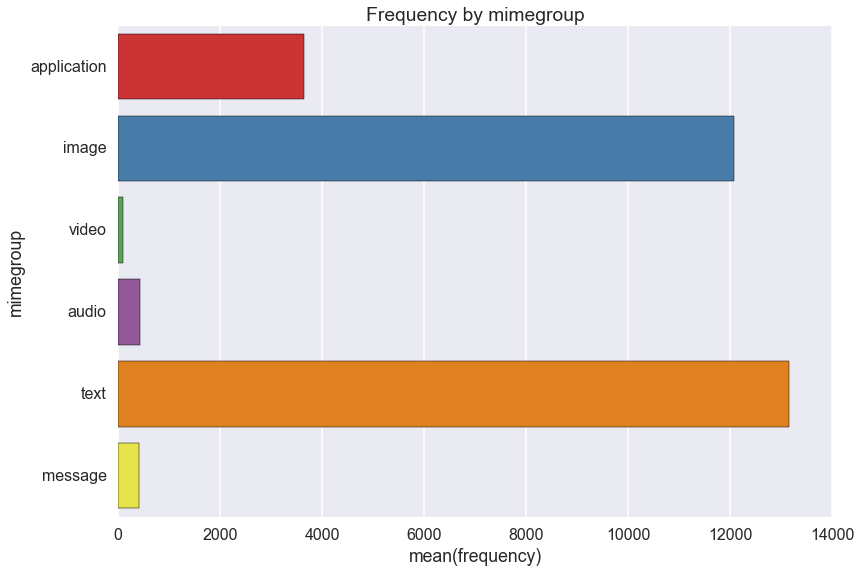

In [17]:
ax = sns.barplot(x="frequency", y="mimegroup", ci=None, data=df)
ax.set(title="Frequency by mimegroup")

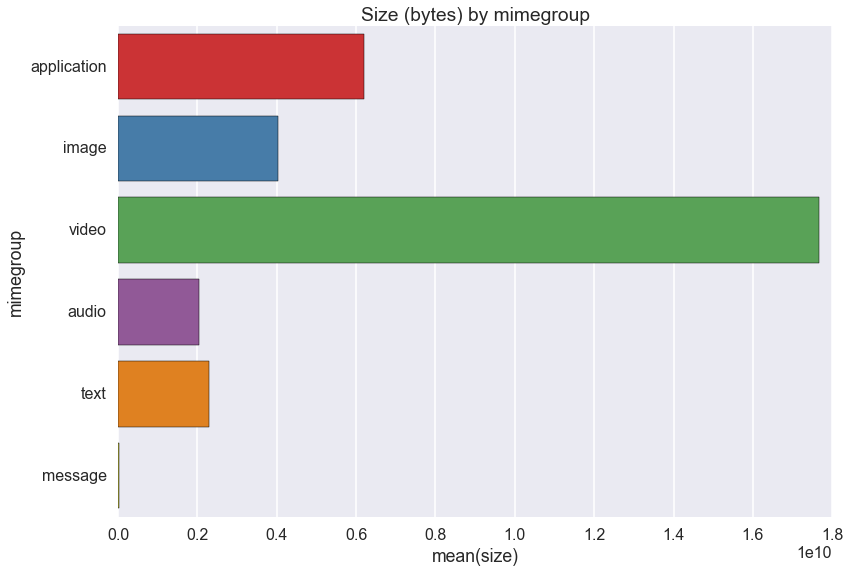

In [18]:
ax = sns.barplot(x="size", y="mimegroup", ci=None, data=df)
ax.set(title="Size (bytes) by mimegroup")

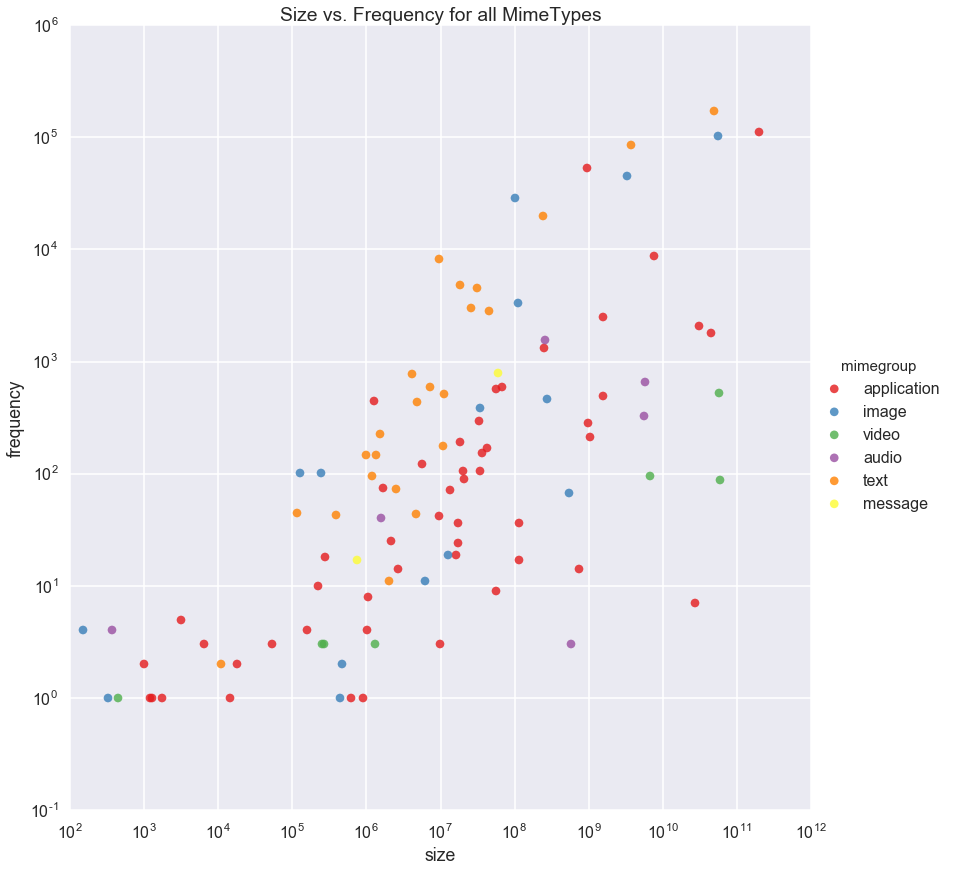

In [19]:
axe = sns.lmplot("size", "frequency", data=df, hue='mimegroup', fit_reg=False, size=12, aspect=1, scatter_kws={"s": 75})
axe.set(xscale="log", yscale="log", title="Size vs. Frequency for all MimeTypes")